# UAV Damage Prediction

Here we use Live dataset saved on Firebase

In [1]:
import requests
import pandas as pd

In [2]:
firebase_url = "https://dr-uav-default-rtdb.europe-west1.firebasedatabase.app/.json"

In [3]:
response = requests.get(firebase_url)
data = response.json()

In [4]:
print(data)

{'Error Found': {'-OJUlDmlFCbyfN4e84f9': {'timestamp': 1739994754225, 'type': 'QR', 'value': 'softwere ERROR '}, '-OJUlGLPmf_TtbP1Tx6d': {'timestamp': 1739994764755, 'type': 'damage', 'value': 'softwere ERROR '}, '-OJUlQzzPKf-rtc1neo3': {'timestamp': 1739994808376, 'type': 'damage', 'value': 'Scratches'}, '-OJUlXEYlHzrABbkya0S': {'timestamp': 1739994833948, 'type': 'damage', 'value': 'Pitted'}, '-OJUm48b_ZE-tHn9f8eM': {'timestamp': 1739994976925, 'type': 'damage', 'value': 'Pitted'}, '-OJUmHdijnxD0R4SPk5g': {'timestamp': 1739995032174, 'type': 'damage', 'value': 'Inclusion'}, '-OJUuGuW3zkb2plg3FmZ': {'timestamp': 1739997126305, 'type': 'damage', 'value': 'Scratches'}, '-OJUuI6iq-WejhR0EUST': {'timestamp': 1739997131298, 'type': 'damage', 'value': 'Scratches'}, '-OJUuOpTftpaY7x4lKmP': {'timestamp': 1739997158803, 'type': 'damage', 'value': 'Pitted'}, '-OJUuRmESI2aLDPKCYO-': {'timestamp': 1739997170884, 'type': 'damage', 'value': 'Pitted'}, '-OJUuTY1YALo_gAnuXIT': {'timestamp': 173999717

# Data Cleaning

In [5]:
failure_data = data.get("Error Found", {})
records = []
for key, record in failure_data.items():
    if isinstance(record, dict) and all(k in record for k in ['timestamp', 'type', 'value']):
        records.append(record)

print("Extracted failure records:")
print(records[:3])

Extracted failure records:
[{'timestamp': 1739994754225, 'type': 'QR', 'value': 'softwere ERROR '}, {'timestamp': 1739994764755, 'type': 'damage', 'value': 'softwere ERROR '}, {'timestamp': 1739994808376, 'type': 'damage', 'value': 'Scratches'}]


* Data Structure

In [6]:
df = pd.DataFrame(records)
print("DataFrame columns:", df.columns)

DataFrame columns: Index(['timestamp', 'type', 'value'], dtype='object')


# Convert Data into Time & Date format

In [7]:
# 3. Convert timestamp and sort by time
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df = df.sort_values("timestamp").reset_index(drop=True)

# Create additional time-based features
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek

In [8]:
print("Preprocessed DataFrame:")
print(df.head())

Preprocessed DataFrame:
                timestamp    type            value  hour  dayofweek
0 2025-02-19 19:52:34.225      QR  softwere ERROR     19          2
1 2025-02-19 19:52:44.755  damage  softwere ERROR     19          2
2 2025-02-19 19:53:28.376  damage        Scratches    19          2
3 2025-02-19 19:53:53.948  damage           Pitted    19          2
4 2025-02-19 19:56:16.925  damage           Pitted    19          2


In [9]:
# Aggregate errors per day
df['date'] = df['timestamp'].dt.date
daily_errors = df.groupby('date').size().reset_index(name='errors')
daily_errors.rename(columns={'date': 'ds', 'errors': 'y'}, inplace=True)
daily_errors['ds'] = pd.to_datetime(daily_errors['ds'])

# Model Training

In [10]:
from prophet import Prophet
import matplotlib.pyplot as plt

In [11]:
model = Prophet()
model.fit(daily_errors)

01:39:55 - cmdstanpy - INFO - Chain [1] start processing
01:39:55 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

In [13]:
maintenance_threshold = 50 

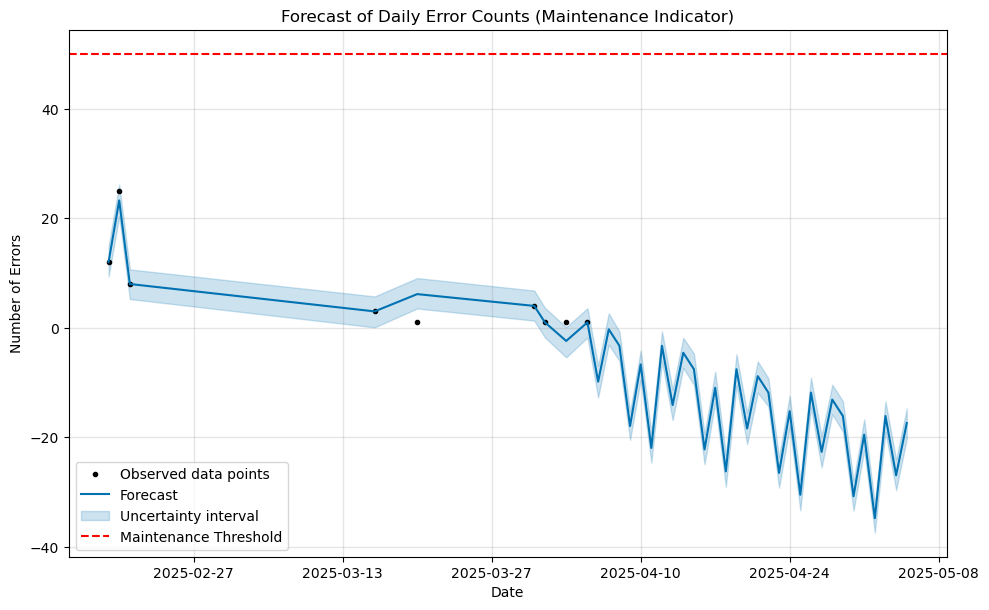

In [14]:
fig = model.plot(forecast)
plt.axhline(y=maintenance_threshold, color='r', linestyle='--', label='Maintenance Threshold')
plt.legend()
plt.title("Forecast of Daily Error Counts (Maintenance Indicator)")
plt.xlabel("Date")
plt.ylabel("Number of Errors")
plt.show()

# Maintennance Date Prediction

In [15]:
future_maintenance_dates = forecast[forecast['yhat'] > maintenance_threshold]['ds']

In [16]:
import firebase_admin
from firebase_admin import credentials, db
import os

In [17]:
firebase_json_path = r"D:\Data centr\DataBase\dr-uav-firebase-adminsdk-fbsvc-a37b23e08a.json"
firebase_app_url= "https://dr-uav-default-rtdb.europe-west1.firebasedatabase.app/"

In [18]:
if not os.path.exists(firebase_json_path):
    print("Firebase credentials file not found!")
else:
    print("Firebase credentials file exists.")

Firebase credentials file exists.


In [19]:
# Initialize Firebase (only if not already initialized)
if not firebase_admin._apps:
    cred = credentials.Certificate(firebase_json_path)
    firebase_admin.initialize_app(cred, {'databaseURL': firebase_app_url})


In [20]:
if not future_maintenance_dates.empty:
    next_maintenance_date = str(future_maintenance_dates.iloc[0])
    
    # 🔹 Store Maintenance Schedule in Firebase
    ref = db.reference("maintenance_schedule")
    ref.set({"next_maintenance_date": next_maintenance_date})

    print(f"Next maintenance date stored in Firebase: {next_maintenance_date}")

# Function to send push notification

In [21]:
from firebase_admin import messaging

In [22]:
firebase_url = firebase_app_url.rstrip('/')

In [24]:
from firebase_admin import messaging

# Function to send push notification
def send_notification():
    message = messaging.Message(
        notification=messaging.Notification(
            title="🚁 UAV Maintenance Reminder",
            body=f"Upcoming maintenance scheduled on {next_maintenance_date}"
        ),
        topic="UAV_Maintenance"
    )
    response = messaging.send(message)
    print(f"Notification sent: {response}")

send_notification

<function __main__.send_notification()>